
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load EPEACS module
from epeacs.agents.epeacs import EPEACS, Configuration

from epeacs.agents.epeacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from epeacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - EPEACS

## Common parameters

In [2]:
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Maze10-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
METRICS_TRIAL_FREQUENCY_EXPLORE = 20
BETA_ALP = 0.05
BETA_RL = 0.05
BETA_PEP = 0.01
EPSILON = 0.8

DO_GA = False
ENABLE_PEP = True

SLIPPERY_PROB = 0.

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ A ■ ■ ■ ■ ■ □ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ $ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of EPEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = EPEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1min 41s, sys: 629 ms, total: 1min 42s
Wall time: 1min 49s


### Performance

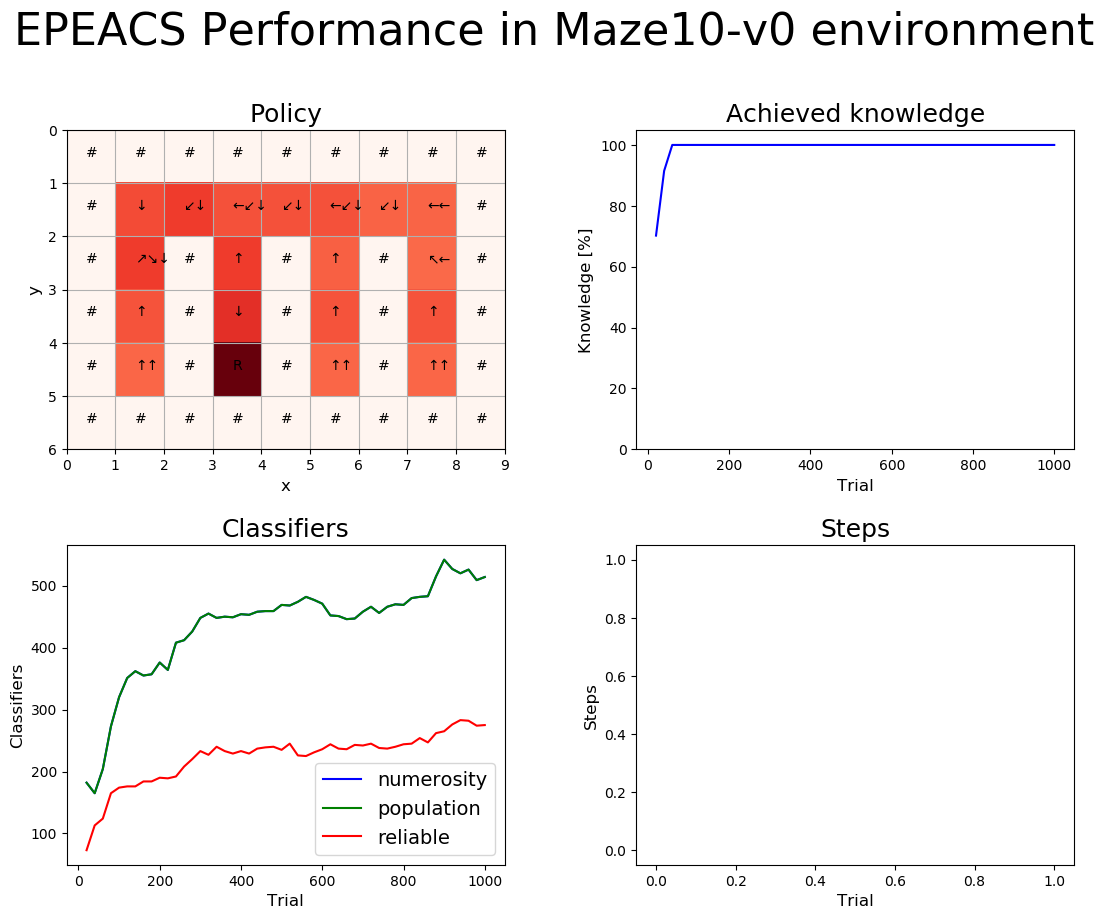

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 100.0, 'population': 514, 'numerosity': 514, 'reliable': 275}
Full knowledge was achieved at trials  60 , was stable at  60  and the last time it was achieved at  1000
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.5359090909090909
{'trial': 1000, 'steps_in_trial': 7, 'reward': 1000, 'knowledge': 100.0, 'population': 514, 'numerosity': 514, 'reliable': 275}
Accumulated Error on PEP Probabilities : old-> 0.2153427998265011 % new-> 0.20120883587371718 %


In [7]:
population_explore.sort(key=lambda cl: -cl.exp * cl.num)
population_explore_to_display = [(cl.condition, cl.action, cl.effect, cl.exp, cl.num) for cl in population_explore
    if cl.is_reliable() and cl.is_enhanced()]
for cl in population_explore_to_display:
    print(cl)
    print(cl[2].print_detailled_counter())
    print("\n")

(01110111, 0, #{0:74.38% (89.75%), 1:25.62% (10.25%)}#####{1:54.46% (47.92%), 0:45.54% (52.08%)}, 1462, 1)
00110111:#700, 00110110:#612, 01110110:#149


(01110#11, 0, #{0:74.38% (89.72%), 1:25.62% (10.28%)}#####{1:54.46% (47.84%), 0:45.54% (52.16%)}, 1458, 1)
00110110:#611, 01110110:#149, 00110111:#697


(01#10#11, 0, #{0:74.38% (89.77%), 1:25.62% (10.23%)}#####{1:54.46% (47.84%), 0:45.54% (52.16%)}, 1455, 1)
00110111:#696, 00110110:#610, 01110110:#148


(01110##1, 0, #{0:74.38% (89.64%), 1:25.62% (10.36%)}#####{1:54.46% (47.52%), 0:45.54% (52.48%)}, 1428, 1)
01110110:#147, 00110111:#678, 00110110:#602


(01#10##1, 0, #{0:74.38% (89.76%), 1:25.62% (10.24%)}#####{1:54.46% (47.55%), 0:45.54% (52.45%)}, 1425, 1)
00110111:#677, 01110110:#145, 00110110:#602


(011#0#11, 0, #{0:74.38% (89.58%), 1:25.62% (10.42%)}#####{1:54.46% (45.85%), 0:45.54% (54.15%)}, 1372, 1)
01110110:#142, 00110110:#600, 00110111:#629


(011#0##1, 0, #{0:74.37% (90.33%), 1:25.63% (9.67%)}#####{1:54.46% (46.79%), 0:45.

In [8]:
agent_explore.get_pai_states_memory()

[('0', '1', '1', '1', '0', '1', '1', '1'),
 ('0', '0', '1', '1', '0', '1', '1', '0'),
 ('1', '1', '0', '0', '1', '0', '0', '1')]

## Training of EPEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = EPEACS(cfg_exploit_no_rl, population_explore)
#agent_exploit_no_rl.zip_population()
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 11.1 s, sys: 33.4 ms, total: 11.1 s
Wall time: 11.3 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = EPEACS(cfg_exploit_rl_start, population_exploit_no_rl)
#agent_exploit_rl_start.zip_population()
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 11.6 s, sys: 68.2 ms, total: 11.7 s
Wall time: 12.4 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = EPEACS(cfg_exploit_rl, population_exploit_rl_start)
#agent_exploit_rl.zip_population()
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 11.9 s, sys: 104 ms, total: 12 s
Wall time: 13.2 s


### Performance

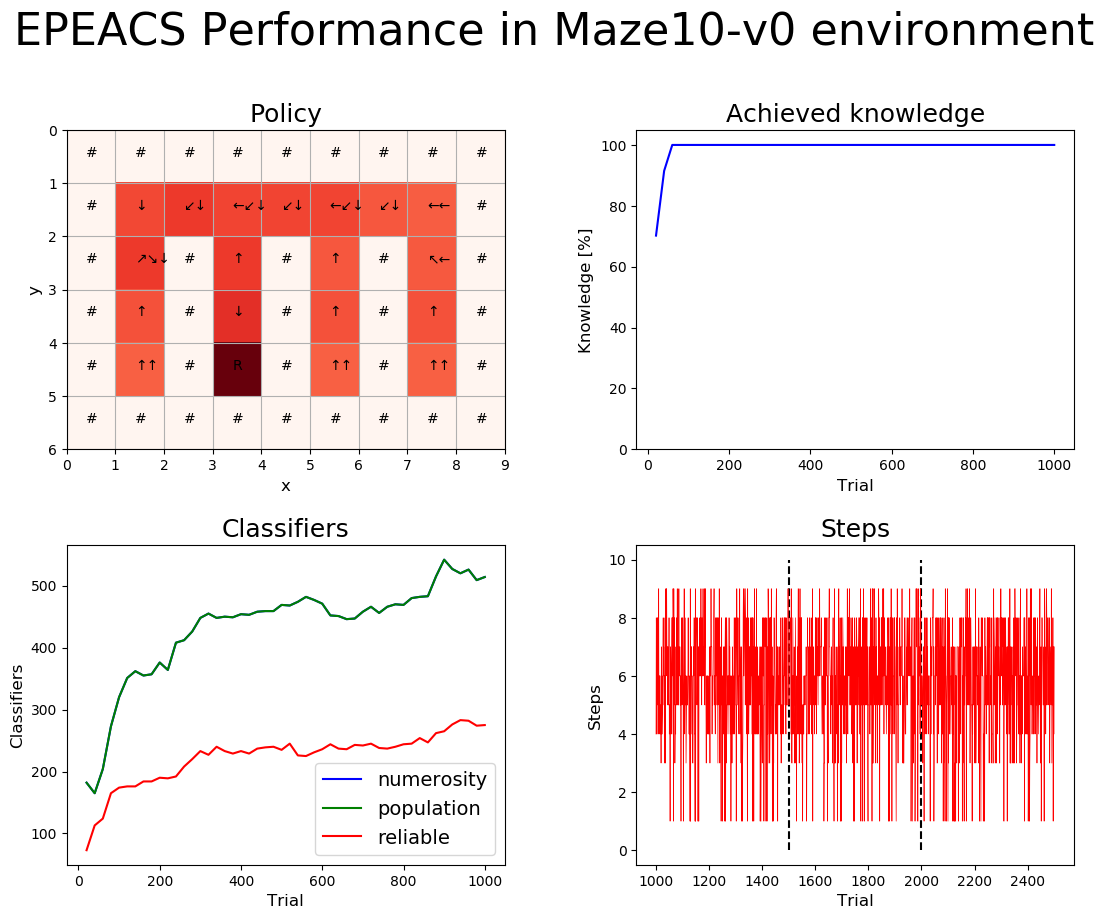

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  41.7  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  5.728  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  5.832  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  5.718  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 514, 'numerosity': 514, 'reliable': 275}
{'knowledge': 100.0, 'population': 514, 'numerosity': 514, 'reliable': 275}
{'knowledge': 100.0, 'population': 514, 'numerosity': 514, 'reliable': 275}
{'knowledge': 100.0, 'population': 514, 'numerosity': 514, 'reliable': 275}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [(cl.condition, cl.action, cl.behavioral_sequence, cl.effect, cl.ee, cl.fitness, cl.exp, cl.num) 
    for cl in population_exploit_rl]
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

(####9###, 4, None, ####1###, False, 999.9977345947129, 903, 1)


(####9###, 1, None, ########, False, 948.7122253643457, 336, 1)


(####9##1, 1, None, ########, False, 948.6155112275644, 335, 1)


(####91##, 2, None, ########, False, 948.0277694006718, 340, 1)


(####9###, 7, None, ########, False, 947.9897457207097, 371, 1)


(###19###, 2, None, ########, False, 947.8111424375091, 339, 1)


(####9#1#, 2, None, ########, False, 946.8576936500228, 331, 1)


(###19#1#, 2, None, ########, False, 946.4630357093259, 330, 1)


(####911#, 2, None, ########, False, 945.8907615335297, 329, 1)


(####9###, 2, None, ########, False, 945.4312993635048, 335, 1)


(00110111, 1, [3, 4], #1##9###, False, 945.2435935049501, 519, 1)


(#1##9###, 7, None, ########, False, 939.1164651264328, 397, 1)


(##1#9###, 6, None, ########, False, 936.6797853973652, 206, 1)


(01#19##1, 0, [4], ########, False, 921.5977850486524, 143, 1)


(#1##9#11, 0, [4], ########, False, 921.4156258048334, 144, 1)


(11010101,